## description

고정된 가격이 아니라 최적의 이익을 기대할 수 있는 방향으로 가격을 업데이트 하는것이 합리적인 선택이다. 가격 선택의 이면에는 다양한 근거들이 존재하지만 결국은 최적의 이익이 목표가 되야한다. "이익" 이라는 것은 단순히 눈에 보이는 매출일 수도 있고 잠재적인 가치 또는 주관적인 가치들일 수도 있다. 우선의 시작은 숫자인 "매출"의 극대화를 목표로 가격선택의 방향을 잡아보자.

## related work

**Multi-armed-bandit(MAB)**


**demand theory**
* 가격이 0이면 모두다 구매할것.
* 가격에 따라 수용하는 정도가 다 다름.
* 수요곡선은 우하향 하는 그래프(x축 가격, y축 수요)
* profit = demand x price
* 다양한 수요곡선

## 1. basic bayesian base algorithm

기본 알고리즘의 구성은 다음과 같다.

    1). 가격 제시
        - 초기 가격은 임의로 정한 범위내에서 랜덤 생성
        
    2). 제시된 가격에 따른 전환율
        - 전환율은 베타분포를 이용한 thompson sampling으로 산출
    
    3). 이익 계산과 다음가격 선정.
        - 이익을 계산하여 이익이 최대화 되는지점을 찾아감. 다만 휴리스틱한 방법임
    
    4). 1~3 반복.
    
<br>

**가정**
* 수요 곡선 대신 전환율 곡선을 임의로 선정. 실제로는 알수없는 함수
* 이익은 가격 x 전환율 로 계산함.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# 수요(전환율) 곡선
def demand_func(price):
    return np.exp(-np.array(price)*0.0001)

# 이익 계산 : 가격 x 전환율
def profit_func(price, demand):
    return np.array(price) * demand

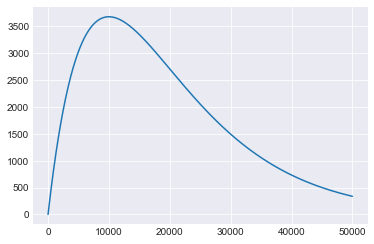

In [9]:
# 가정한 수요곡선
x = np.linspace(0,50000,1000)
y = profit_func(x, demand_func(x))
plt.plot(x,y)

In [13]:
class MAB:
    """
    알고리즘에 의해 선택된 bandit을 draw하는 역할
    * input : 해당 가격에 대응되는 소비자들의 전환율
    * output : 0(유보) or 1(구매)
    """
    
    def __init__(self, bandit_probs):
        self.bandit_probs = bandit_probs
        
     
    # reward
    def draw(self):
        reward = np.random.binomial(1,self.bandit_probs)
        return reward

In [48]:
# 베타분포 평균/분산 계산
def calculator(alpha,beta):
    """
    베타분포의 평균/분산 을 구하는 함수
    * input : alpha, beta
    * output : mean, variance
    """
    mean = alpha/(alpha+beta)
    var = (alpha*beta)/(((alpha+beta)**2)*(alpha+beta+1))
    return mean, var

# 베타분포 모수 계산
def param(success, fail):
    """
    베타분포 모수 계산 함수
    * input : 구매유저수, 구매하지않은 유저수
    * output : alpha, beta
    """
    alpha, beta = 1+success, 1+fail
    return alpha, beta

# 샘플링 policy. 다른 샘플링 방법으로 대체 할 수 있음.
def thompson(success, fail):
    """
    소비자들의 피드백을 이용하여 해당 가격의 전환율 계산. 샘플링 방법
    * input : 구매유저수, 구매하지않은 유저수
    * output : 전환율
    """
    alpha, beta = param(success, fail)
    mean, var = calculator(alpha, beta)
    
    #thompson
    rvs = np.random.beta(alpha,beta)
    return rvs

def UCB(success, fail):
    """
    소비자들의 피드백을 이용하여 해당 가격의 전환율 계산
    * input : 구매유저수, 구매하지않은 유저수
    * output : 전환율
    """
    Q = (success/(success+fail)) # 각 bandit의 평균 성공확률
    c = 2 
    N = success+fail # 각 bandit의 총 선택된 횟수.
    rvs = np.argmax(Q + c*np.sqrt(np.log(N.sum())/N))
    return rvs  


# 다음 가격 제시 함수    
def pricing(price, rvs):
    """
    제시된 가격에 반응하는 소비자의 전환율을 토대로 다음 가격 제시
    * input : 가격, 전환율
    * output : 다음가격
    """
    sort_price = np.sort(price)[::-1]
    range_price = sort_price[0] - sort_price[-1]
    profit =  rvs * price 
        
    k = np.argmax(profit)
    opt_price = price[k]
    which_opt = np.where(sort_price==opt_price)[0][0]
    
    # 다음 가격 정하기.
    if sort_price[0] == opt_price :
        interval = sort_price[0] - sort_price[1]
              
        next_price = np.random.uniform(np.max([opt_price-interval,0]), opt_price, 2).tolist()+np.random.uniform(opt_price, opt_price*1.1, 2).tolist() 
    
    elif sort_price[-1] == opt_price :
        
        interval = sort_price[-2] - sort_price[-1]
        
        next_price = np.random.uniform(opt_price*0.9, opt_price, 2).tolist()+np.random.uniform(opt_price, opt_price+interval, 2).tolist() 
        
    else :
        
        lower, upper = sort_price[which_opt] - sort_price[which_opt+1], sort_price[which_opt-1] - sort_price[which_opt]
        next_price = np.random.uniform(sort_price[which_opt-1], sort_price[which_opt+1],2).tolist() + [sort_price[which_opt-1], sort_price[which_opt+1]]
        

    return np.sort(next_price)

In [43]:
# 시뮬레이션 함수
def simulator(n,  price, policy):
    """
    전체 프로세스 시뮬레이션
    * input : 테스트하는 소비자들의 수(n) ,가격
    * output : 다음 가격
    
    """
    reward_array = np.zeros((len(price), n))
    opt_history = []
    
    test=MAB(demand_func(price))
    for i in range(n):
        reward_array[:,i] = test.draw()
    
    success = reward_array.sum(axis=1)
    fail = n - success
    rvs = policy(success, fail)
    
    next_price = pricing(price,rvs)
    return next_price, price * rvs

In [46]:
def history(n, x_bound, policy):
    """
    기록저장 함수
    * input : 가격제시 횟수, 초기 가격 범위
    * output : 가격 log, 이익 log
    """
    price_history = np.zeros((4,n))
    profit_history = np.zeros((4,n))
    initial_price = np.random.uniform(x_bound[0],x_bound[1], 4)
    next_price, profit = simulator(n, initial_price, policy)
    
    price_history[:, 0] = initial_price
    profit_history[:, 0] = profit
    price_history[:, 1] = next_price
    
    for i in range(1,n):
        next_price, profit = simulator(1000, next_price, policy)
        
        if i==n-1:
            profit_history[:, i] = profit
        else :
            price_history[:, i+1] = next_price
            profit_history[:, i] = profit
        
    return price_history, profit_history

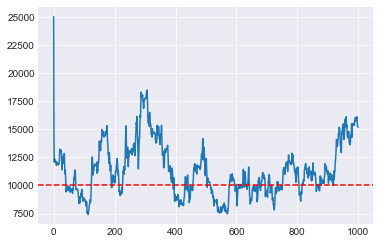

In [49]:
price, profit = history(1000, (0,50000), thompson)
plt.plot(price.mean(axis=0))
plt.axhline(y = x[np.argmax(y)], ls='--', color='r')

실제 최적의 가격 선에 fluctuatio하는것을 볼수 있음.

### 문제점
* "다음 가격 선택" 의 단계의 근본적인 문제.휴리스틱한 방법이라 근거가 없음.

## 2.GP optimize

*Thompson Sampling for Infinite-Armed Bandits*  
베이지안 최적화의 방법과 근본적으로는 동일함. 커널과 hper-parameter를 잘선택하는 것이 중요하게 작용. 지금의 문제처럼 단위가 큰 경우는 더더욱 중요함. 목적함수를 최대화 하는것이 목표.
알고리즘의 구성은 다음과 같다.
    
    1. 가격 제시
        - 초기에는 랜덤하게 가격 선택
        
    2. 주어진 가격과 이익함수(objective function)의 데이터를 근거로 하여 가우시안 프로세스 적용.
    
    3. 관측치를 지나는 사후분포중 하나를 샘플링
    
    4.사후분포의 값 중에서 가장큰 이익의 값을 가지는 가격을 다음 테스트 포인트로 선택
    
    5. 반복

하이퍼 파라미터를 어떻게 선택해야할지가 문제. 우선은 베이지안 추론.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
import pymc3 as pm
import warnings; warnings.filterwarnings("ignore")

plt.ioff()
plt.style.use('seaborn-darkgrid')

In [51]:
# hyper-param 추론
import pymc3 as pm

# 현재 10개의 가격에 대한 목적함수값을 알고있다고 가정.
X_obs = np.random.uniform(0,50000, 10)[:,None]
Y_obs = obj_func(X_obs)

with pm.Model() as model:
    length = pm.Uniform('length', lower=0 , upper=10000) # 범위를 넓게 선택.

    cov = pm.gp.cov.Exponential(1, length)
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfCauchy("sigma", beta=10000) # 오차범위도 마찬가지로 넓게 
    y_ = gp.marginal_likelihood("y", X=X_obs, y=Y_obs, noise=sigma)

    mp = pm.find_MAP()

pd.DataFrame({"Parameter": ["length", "sigma"],
              "Value at MAP": [float(mp["length"]),  float(mp["sigma"])]})

logp = -952.95, ||grad|| = 94.678: 100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00, 22.80it/s]


,Parameter,Value at MAP
0,length,5000.000570
1,sigma,2512.923045


In [50]:
# thompson sampling 기반 GP optimize
class thompsonGP:
    """
    GP 사후분포 계산 및 가격선택
    """
    def __init__(self, n_random_draws, objective, x_bound, interval_resolution=1000):
        self.n_random_draws = n_random_draws
        self.objective = objective
        self.bounds = x_bound
        self.interval_resolution = interval_resolution
        self.X_grid = np.linspace(self.bounds[0], self.bounds[1], self.interval_resolution)
        self.X, self.Y = np.array([]), np.array([])
        
    # GP fit. hyper-param을 잘 선택해야함.    
    def fit(self, X, Y):
        K = RBF(length_scale=5000)
        gp = GaussianProcessRegressor(kernel=K)
        gp.fit(X,Y)
        return gp
    
    
    def choose_next_sample(self):
        
        if self.X.shape[0] < self.n_random_draws:
            next_sample = np.random.uniform(self.bounds[0], self.bounds[1],1)[0]
            
        else : 
            # GP fit
            self.gp = self.fit(self.X.reshape(-1,1), self.Y)
            
            # 사후분포중 하나를 샘플링.
            posterior_sample = self.gp.sample_y(self.X_grid.reshape(-1,1), 1).T[0]
            
            # 다음테스트 포인트 선택
            which_max = np.argmax(posterior_sample)
            next_sample = self.X_grid[which_max]
            
            # 평균, 분산 계산.
            posterior_mean , posterior_std = self.gp.predict(self.X_grid.reshape(-1,1), return_std=True)
        
        next_observation = self.objective(next_sample)
        self.X = np.append(self.X, next_sample)
        self.Y = np.append(self.Y, next_observation)
        
        try :
            return self.X, self.Y, self.X_grid, posterior_sample, posterior_mean, posterior_std
        
        except:
            return self.X, self.Y, self.X_grid, np.array([np.mean(self.Y)]*self.interval_resolution), np.array([np.mean(self.Y)]*self.interval_resolution), np.array([0]*self.interval_resolution) 

In [ ]:
def ts_gp_plotting(ts_gp, max_rounds):
    
    round_dict = {}
    
    for round_id in range(max_rounds):
        
        x_obs, y_obs, x_grid, post_sample , post_mean, post_std = ts_gp.choose_next_sample()
        
        round_dict[round_id] = {'x_obs' : x_obs,
                               'y_obs' : y_obs, 
                               'x_grid' : x_grid,
                               'post_sample' : post_sample,
                               'post_mean' : post_mean, 
                               'post_std' : post_std}
        
    fig, ax = plt.subplots(figsize=[10,4], dpi=150)
    
    ax.plot(X,Y, 'k--', linewidth=2, label='actual function')
    ax.plot(round_dict[0]['x_obs'], round_dict[0]['y_obs'], 'bo', label="GP- sample obj func",
            alpha=0.7)
    ax.plot(round_dict[0]['x_grid'], round_dict[0]['post_sample'], 'r', linewidth=2, label='sample from posterior',
            alpha=0.7)
    ax.fill_between(round_dict[0]['x_grid'], round_dict[0]['post_mean']-round_dict[0]['post_std'],
                    round_dict[0]['post_mean']+round_dict[0]['post_std'], alpha=0.2, color='r')
    plt.title("""obj function TS-GP optimizaion""", fontsize=14)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    ax.set_ylim(0,4000)
        
    def animate(i):
        ax.clear()
        ax.plot(X,Y, 'k--', linewidth=2, label='actual func')
        ax.plot(round_dict[i]['x_obs'], round_dict[i]['y_obs'], 'bo', label="GP- sample obj func",
            alpha=0.7)
        ax.plot(round_dict[i]['x_grid'], round_dict[i]['post_sample'], 'r', linewidth=2, label='sample from posterior',
                alpha=0.7)
        ax.fill_between(round_dict[i]['x_grid'], round_dict[i]['post_mean']-round_dict[i]['post_std'],
                        round_dict[i]['post_mean']+round_dict[i]['post_std'], alpha=0.2, color='r')
        plt.title("""obj function at TS-GP optimizaion""", fontsize=14)
        plt.xlabel('$x$')
        plt.ylabel('$y$')
        ax.set_ylim(0,4000)
        return ()

    anim = FuncAnimation(fig, animate, frames=max_rounds, interval=3500, blit=True)

    return HTML(anim.to_html5_video())

In [ ]:
ts_gp = thompsonGP(n_random_draws=3, objective=obj_func, x_bound = (0,50000))

X = np.linspace(0, 50000, 10000)
Y = obj_func(X)

In [ ]:
ts_gp_plotting(ts_gp, 20)

### 3. more demand theory
* 가격이 $p_k$ 인 상품을 구매하는 소비자라면, 가격이 $p_k$ 이하인 경우는 항상 구매함
* 소비자들마다 각각의 상품에 대한 상한가가 있음.
    * $\theta_k$ 는 $p_k$를 구매하는 최고가임. 수식적으로, $\theta_k - p_k >0$ 이고, $\theta_k - p_{k+1} < 0$ 임.
* 반복적으로 구매 되는 상품이라면 구매의 경계를 정할수있음.
    * 상품을 3원에 구입했고, 8원에는 하지않았음. 또 2원에 구입했고 6원에도 하지않았음. 정보를 토대로한 이 상품의 실제 선호 경계는 3원과 6원 사이일것.


**notation**
* $n_{s,t}$ : t 시점에서 s그룹의 가격실험횟수
* $D(p_k)_{s,t} \in (0,1)$. 고객들의 가격수요경계에따라 달라짐
* $p_s^{min}$ : s 그룹의 모든 고객이 수용할 수 있는 금액 최대치.
* $p_s^{max}$ : s 그룹의 모든 고객이 수용 못하는 금액으 최저치